continuing with the age old dog vs cat classifier now using the concept of transfer learning by implementing an already popular model in open source communities

In [1]:
import os
import pickle

import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import InceptionV3

import matplotlib.pyplot as plt

from io import BytesIO
from ipywidgets import widgets

2025-07-22 15:56:57.198771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753180017.211308   28633 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753180017.215415   28633 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753180017.225749   28633 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753180017.225765   28633 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753180017.225766   28633 computation_placer.cc:177] computation placer alr

In [2]:
TRAIN_DIR = 'train'
VAL_DIR   = 'test'

train_dogs_dir   = os.path.join(TRAIN_DIR, 'dogs')
train_cats_dir   = os.path.join(TRAIN_DIR, 'cats')
validate_dogs_dir = os.path.join(VAL_DIR, 'dogs')
validate_cats_dir = os.path.join(VAL_DIR, 'cats')

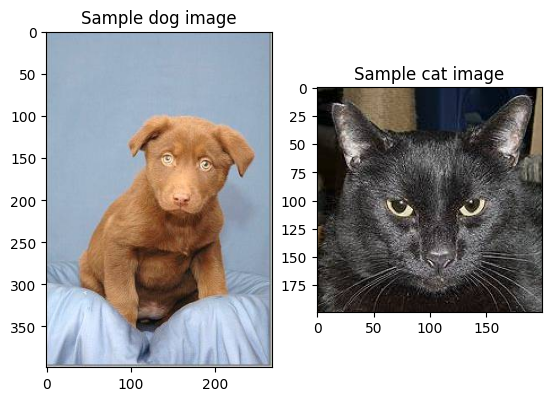

In [3]:
sample_image_dog  = tf.keras.preprocessing.image.load_img(os.path.join(train_dogs_dir, os.listdir(train_dogs_dir)[0]))
sample_image_cat  = tf.keras.preprocessing.image.load_img(os.path.join(train_cats_dir, os.listdir(train_cats_dir)[0]))

ax = plt.subplot(1,2,1)
ax.imshow(sample_image_dog)
ax.set_title('Sample dog image')

ax = plt.subplot(1,2,2)
ax.imshow(sample_image_cat)
ax.set_title('Sample cat image')
plt.show()

In [4]:
sample_array = tf.keras.preprocessing.image.img_to_array(sample_image_cat)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (199, 200, 3)


establishing train_val_datasets

In [5]:
def train_val_datasets():

    training_dataset = tf.keras.utils.image_dataset_from_directory( 
        directory=TRAIN_DIR,
        batch_size=128,
        image_size=(150,150),
        shuffle=True, 
        seed=42
    ) 
    
    validation_dataset = tf.keras.utils.image_dataset_from_directory( 
        directory=VAL_DIR,
        batch_size=128,
        image_size=(150,150),
        shuffle=True, 
        seed=42
    ) 
                                                                        
    return training_dataset, validation_dataset

In [6]:
training_dataset, validation_dataset = train_val_datasets()

Found 20000 files belonging to 2 classes.


I0000 00:00:1753180019.827274   28633 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5076 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 5000 files belonging to 2 classes.


creating test datasets {manual split}

In [7]:
val_batches = int(validation_dataset.cardinality())
test_size = val_batches // 5 

test_dataset = validation_dataset.take(test_size)
validation_dataset = validation_dataset.skip(test_size)

print(f'Number of validation batches: {validation_dataset.cardinality()}')
print(f'Number of test batches: {test_dataset.cardinality()}')

Number of validation batches: 32
Number of test batches: 8


creating the model

In [8]:
def create_pre_trained_model():
  
    pre_trained_model = tf.keras.applications.inception_v3.InceptionV3( 
        include_top=False, 
        input_shape=(150,150,3),
        weights='imagenet'
    ) 

    for layer in pre_trained_model.layers:
        layer.trainable = False

    return pre_trained_model

In [9]:
pre_trained_model = create_pre_trained_model()

num_total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {num_total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


In [10]:
pre_trained_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

standard callback function

In [11]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy']>0.999:
            self.model.stop_training = True
            print("\nReached 99.9% accuracy so cancelling training!")

using our DNN underneath the pretrained model

In [12]:
def output_of_last_layer(pre_trained_model):
    
    last_layer = pre_trained_model.get_layer('mixed7')
    last_output = last_layer.output
    print('last layer output shape: ', last_output.shape)
    
    return last_output

In [13]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)


creating the final model

In [14]:
def create_final_model(pre_trained_model, last_output):

    x = tf.keras.layers.Flatten()(last_output)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense  (1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x)

    model.compile( 
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001), 
        loss='binary_crossentropy', 
        metrics=['accuracy'] 
    )
  
    return model

In [15]:
model = create_final_model(pre_trained_model, last_output)

total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.


preprocessing function

In [16]:
def preprocess(image, label):
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, label

training_dataset = training_dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

In [17]:
history = model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = 20,
    verbose = 2,
    callbacks = [EarlyStoppingCallback()],
)

Epoch 1/20


I0000 00:00:1753180025.794834   28738 service.cc:152] XLA service 0x7efd28002700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753180025.794867   28738 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-07-22 15:57:06.287479: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753180027.327477   28738 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1753180034.704225   28738 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 - 32s - 207ms/step - accuracy: 0.9484 - loss: 0.1444 - val_accuracy: 0.9691 - val_loss: 0.0817
Epoch 2/20
157/157 - 10s - 66ms/step - accuracy: 0.9758 - loss: 0.0656 - val_accuracy: 0.9718 - val_loss: 0.0690
Epoch 3/20
157/157 - 10s - 63ms/step - accuracy: 0.9825 - loss: 0.0514 - val_accuracy: 0.9728 - val_loss: 0.0670
Epoch 4/20
157/157 - 10s - 64ms/step - accuracy: 0.9879 - loss: 0.0408 - val_accuracy: 0.9754 - val_loss: 0.0621
Epoch 5/20
157/157 - 10s - 66ms/step - accuracy: 0.9908 - loss: 0.0338 - val_accuracy: 0.9731 - val_loss: 0.0669
Epoch 6/20
157/157 - 10s - 64ms/step - accuracy: 0.9942 - loss: 0.0282 - val_accuracy: 0.9728 - val_loss: 0.0660
Epoch 7/20
157/157 - 10s - 63ms/step - accuracy: 0.9960 - loss: 0.0233 - val_accuracy: 0.9754 - val_loss: 0.0615
Epoch 8/20
157/157 - 10s - 66ms/step - accuracy: 0.9969 - loss: 0.0203 - val_accuracy: 0.9756 - val_loss: 0.0612
Epoch 9/20
157/157 - 10s - 64ms/step - accuracy: 0.9982 - loss: 0.0176 - val_accuracy: 0.9751 - val_loss: 

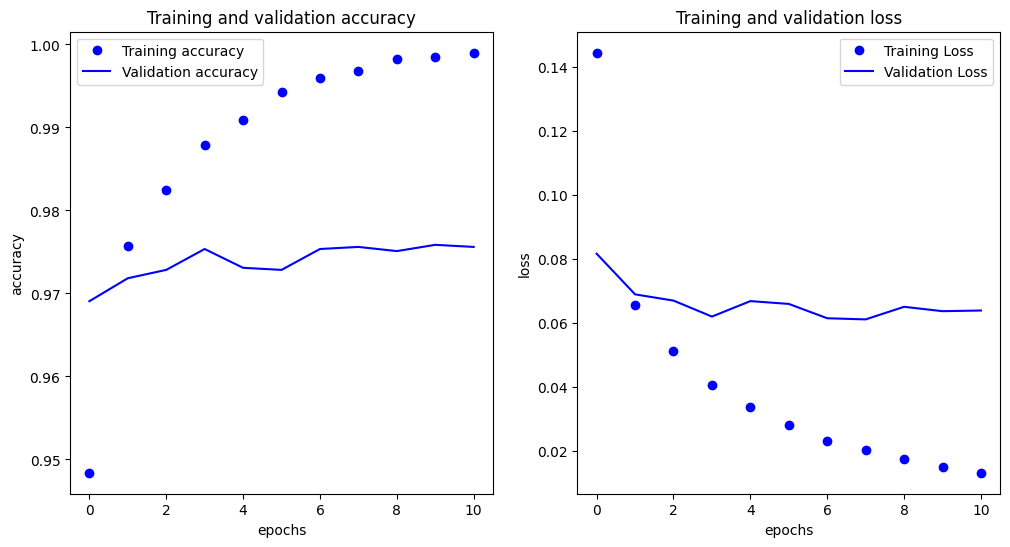

In [18]:
def plot_loss_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()
    
    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()
    
    plt.show()

plot_loss_acc(history)

great results overall , much better than custom built models

now using the test dataset for seeing how it actually performs now on unseen data

In [22]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test loss: {test_loss},\nTest accuracy: {test_accuracy}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9679 - loss: 0.0635
Test loss: 0.05173538625240326,
Test accuracy: 0.9765625


In [19]:
rescale_layer = tf.keras.layers.Rescaling(1./255)

In [20]:
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    image = tf.keras.utils.load_img(file, target_size=(150, 150))
    image = tf.keras.utils.img_to_array(image)
    image = rescale_layer(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = model.predict(image, verbose=0)[0][0]
    
    with out:
        if prediction > 0.5:
            print(filename + " is a dog")
        else:
            print(filename + " is a cat")


def on_upload_change(change):
    
    items = change.new
    for item in items: 
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)

uploader.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()

In [23]:
with open('model.pkl','wb') as f:
    pickle.dump(history.history , f)